In [1]:
# Import những thư viên cần thiết
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
# Sử dụng thư viện Keras để tiền xử lý hình ảnh.
from keras.preprocessing import image
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cv2
from zipfile import ZipFile
import time

2024-06-08 20:18:25.075059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 20:18:25.075243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 20:18:25.238406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['dataset']


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>1 |</span></b> <b>BỘ DỮ LIỆU</b></div>

### <b><span style='color:#8FBC8F'> 1.1 |</span> Mô tả chung</b>
Bộ dữ liệu được lấy từ một cuộc thi được tổ chức trên Kaggle mang tên [Aerial Cactus Identification](https://www.kaggle.com/competitions/aerial-cactus-identification) (Nhận diện xương rồng từ trên không) với mục đích xác định liệu hình ảnh có chứa xương rồng hay không.

### <b><span style='color:#8FBC8F'> 1.2 |</span> Mô tả về cuộc thi</b>

Để đánh giá tác động của biến đổi khí hậu đối với hệ thực vật và động vật trên Trái Đất, việc xác định sự ảnh hưởng từ các hoạt động của con người như chặt phá, khai thác gỗ, và nông nghiệp đến các khu vực tự nhiên được bảo vệ của chúng ta là rất quan trọng. Các nhà nghiên cứu tại Mexico đã tạo dự án [VIGIA](https://jivg.org/research-projects/vigia/), mục tiêu xây dựng một hệ thống giám sát tự động cho các khu vực được bảo vệ. Một bước đầu tiên trong nỗ lực như vậy là khả năng nhận biết thực vật bên trong các khu vực được bảo vệ. Và nhiệm vụ trong cuộc thi này là tạo ra một thuật toán có thể nhận diện loại cây xương rồng cụ thể trong hình ảnh được chụp từ không gian.

### <b><span style='color:#8FBC8F'> 1.3 |</span> Mô tả về bộ dữ liệu</b>
**Thông tin sơ lược:**

Bộ dữ liệu này chứa một số lượng lớn hình ảnh thu nhỏ 32 x 32 chứa ảnh chụp từ trên cao của một loại cây xương rồng trụ (Neobuxbaumia tetetzo). Kaggle đã điều chỉnh kích thước ảnh từ bộ dữ liệu gốc để làm cho chúng cùng kích thước. Tên tệp của một hình ảnh tương ứng với id của nó.

Nhiệm vụ: Tạo một mô hình phân loại có khả năng dự đoán xem một hình ảnh có chứa cây xương rồng hay không.

**Thông tin cụ thể:**

Bộ dữ liệu gồm các file sau: 
-	train: các hình ảnh tập huấn luyện	
-	test: các hình ảnh tập kiểm tra
-	train.csv: các nhãn của tập huấn luyện, cho biết liệu hình ảnh có chứa cây xương rồng hay không (has_cactus = 1)
-	sample_submission.csv - một tệp nộp mẫu theo đúng định dạng.

Ở đây ta sẽ tập trung vào các file là train và train.csv để làm dữ liệu input cho mô hình CNN.



# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>2 |</span></b> <b>TẢI, TIỀN XỬ LÝ VÀ KHÁM PHÁ DỮ LIỆU</b></div>

### <b><span style='color:#8FBC8F'> 2.1 |</span> Tải dữ liệu</b>

In [2]:
train_dir = "/kaggle/input/dataset/train/train/"
#test_dir ="/kaggle/input/dataset/test/test/"
# Tải file chứa nhãn của bộ dữ liệu
train_labels=pd.read_csv("/kaggle/input/dataset/train.csv")
print('Shape of train data:',train_labels.shape)
print('Number of labels in train data:\n', train_labels['has_cactus'].value_counts())

Shape of train data: (17500, 2)
Number of labels in train data:
 has_cactus
1    13136
0     4364
Name: count, dtype: int64


In [3]:
# Tiền xử lý hình ảnh sử dụng thư viện keras
# Tạo list chứa nhãn của hình ảnh
label=[]
# Tạo list chưa ma trận hình ảnh
image_feature = []
image_id=train_labels['id']
for i in image_id:
    # Tải hình ảnh dưới dạng PIL format, có target size là (32,32,3)
    img=image.load_img(train_dir+i, target_size=(32,32))
    # Chuyển đổi hình ảnh dạng PIL thành mảng Numpy
    img = image.img_to_array(img)
    # Thực hiện chuẩn hóa hình ảnh bằng cách chia cho 255.0
    img = img/255.0
    image_feature.append(img)
    label.append(train_labels[train_labels['id'] == i]['has_cactus'].values[0])
# Tạo dataframe từ các hình ảnh đã tiền xử lý và nhãn tương ứng của chúng
list_of_tuples=list(zip(image_feature,label))
df = pd.DataFrame(list_of_tuples, columns = ['image', 'label'])
# Tạo dữ liệu input cho mô hình
X = np.array(image_feature)
y=pd.get_dummies(df['label']).values
# Chuyển đổi dữ liệu có dạng (number of images,number of channels,height image, width image)
X = X.transpose(0,3,1,2)

In [4]:
# Chia dataset thành các tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print("Train Images:",X_train.shape[0])
print("Test Images:",X_test.shape[0])

Train Images: 14000
Test Images: 3500


### <b><span style='color:#8FBC8F'> 2.3 |</span> Khám phá dữ liệu</b>

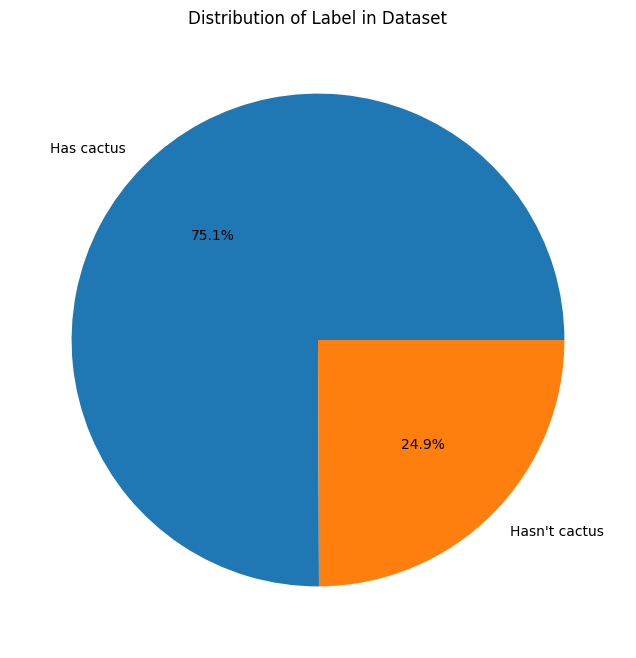

In [5]:
plt.figure(figsize = (8,8))
plt.pie(train_labels['has_cactus'].value_counts(), labels=['Has cactus', 'Hasn\'t cactus'], autopct='%.1f%%')
plt.title('Distribution of Label in Dataset');

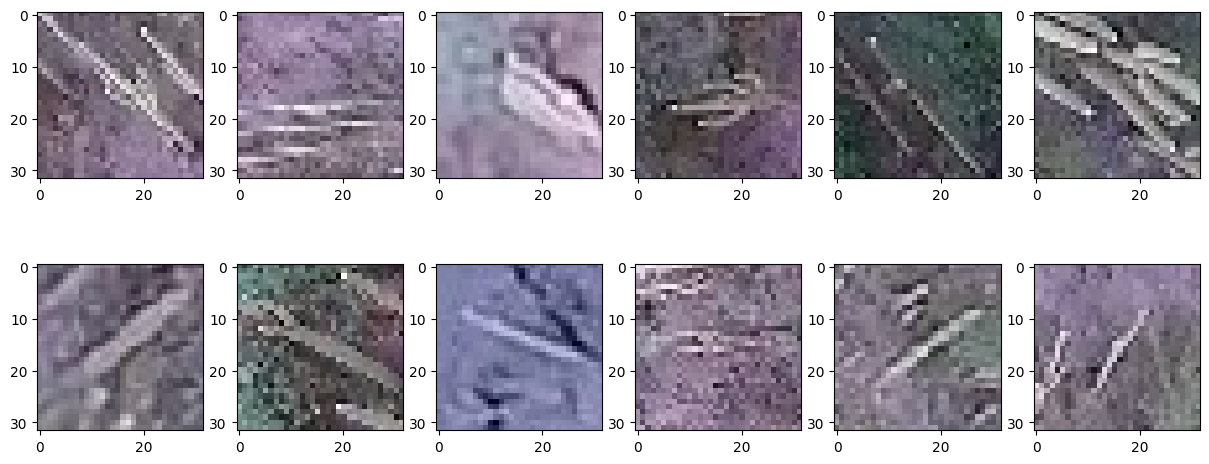

In [6]:
# Trực quan hình ảnh thuộc lớp có xuất hiện hình ảnh xương rồng
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train_labels[train_labels['has_cactus'] == 1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = '/kaggle/input/dataset/train/train/' + img_name
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

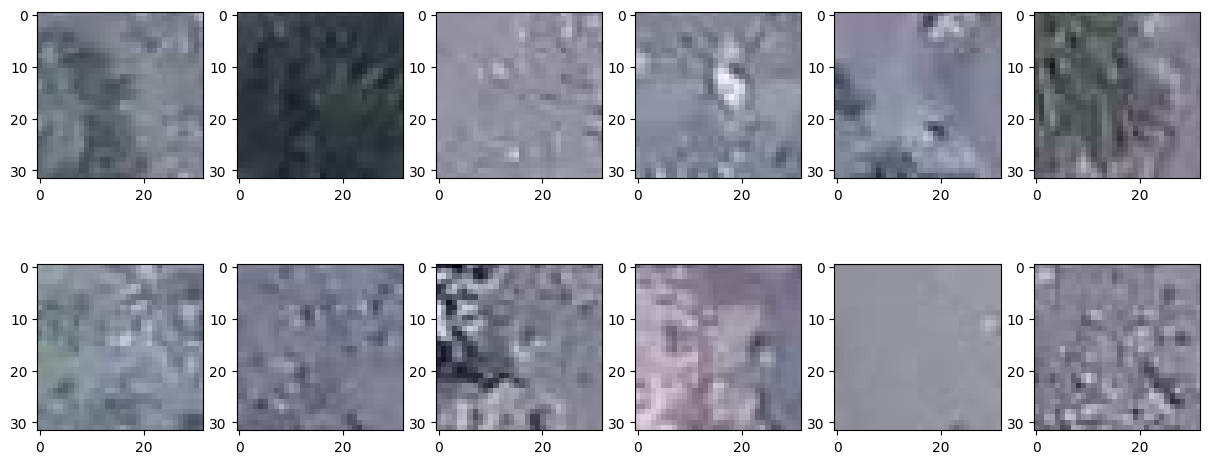

In [7]:
# Trực quan hình ảnh thuộc lớp không có xuất hiện hình ảnh xương rồng
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train_labels[train_labels['has_cactus'] == 0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = '/kaggle/input/dataset/train/train/' + img_name
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>3 |</span></b> <b>CÀI ĐẶT CÁC HÀM </b></div>

### <b><span style='color:#8FBC8F'> 3.1 | </span> Xây dựng CNN model </b>

In [8]:
# Build CNN model
import numpy as np
from numba import cuda
import time
class Layer():

    def forward(self, inputs):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

    def get_out_shape(self):
        pass

    def init_weight(self):
        pass

class CNNModel:
    def __init__(self, layers):#: list(Layer) = []):
        pre_layer = layers[0]
        pre_layer.init_weight()
        for layer in layers[1:]:
            layer.input_shape = pre_layer.get_out_shape()
            layer.init_weight()
            pre_layer = layer
        self.layers: list[Layer] = layers

    def forward(self, X):
        output = X
        for layer in self.layers:
#             start = time.time()
            output = layer.forward(output)
#             end = time.time()
#             print(layer,' forward', end - start)
        return output

    def backward(self, out_grad, learning_rate):
        for layer in reversed(self.layers):
#             start = time.time()
            out_grad = layer.backward(out_grad, learning_rate)
#             end = time.time()
#             print(layer,' backward', end - start)
        return out_grad

    def fit(self, X_train, Y_train, epochs=1, batch_size=32, learning_rate=0.001):
        num_batch = (len(X_train)-1)//batch_size+1
        for i_epoch in range(epochs):
            print(f"\nEpoch {i_epoch+1}/{epochs}:")
            train_loss = 0
            acc = 0
            progress = '.'*30
            for i in range(num_batch-1):

                batch_start = i * batch_size
                batch_end = (i + 1) * batch_size
                batch_X = X_train[batch_start: batch_end]
                batch_Y = Y_train[batch_start: batch_end]
                #start_forward = time.time()
                predictions = self.forward(batch_X)
                #end_forward = time.time()
                #print(end_forward - start_forward)
                out_grad = 2.0 * (predictions - batch_Y)
                #start_backward = time.time()
                self.backward(out_grad, learning_rate)
                #end_backward = time.time()
                #print(end_backward - start_backward)

                # print result
                acc_batch = np.mean(
                    np.argmax(predictions, axis=1) == np.argmax(batch_Y, axis=1))
                acc += acc_batch
                loss = np.sum((predictions - batch_Y) ** 2)
                train_loss += loss
                i_str = int(i/num_batch*30)
                progress = progress[:i_str] + ">" + progress[i_str+1:]
                print(
                    f"\r {i}/{num_batch} [{progress}] accuaray: {acc_batch:.5f}, train loss = {loss/len(batch_Y):.5f}", end='')
                progress = progress[:i_str] + "=" + progress[i_str+1:]

            train_loss /= len(X_train)

            print(
                f"\r {num_batch}/{num_batch} [{progress}] accuaray: {acc/num_batch:.5f}, train loss = {train_loss:.5f}", end='')

    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.forward(X_test)
        acc = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/y_test.shape[0]
        print(f'Accuracy for the test set is {acc}')
        return acc
    
    def use_device(self, value):
        for layer in self.layers:
            output = layer.use_device = value


class Flatten(Layer):
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        pass

    def get_out_shape(self):
        t = 1
        for i in self.input_shape:
            t *= i
        return t

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        return inputs.reshape(inputs.shape[0], -1)

    def backward(self, output_gradient, learning_rate):
        shape = self.inputs.shape
        return output_gradient.reshape(shape)

    def init_weight(self):
        pass

### <b><span style='color:#8FBC8F'> 3.2 | </span> Convolutional Layer </b>

In [9]:
# Convolution Layer
class Convolution(Layer):
    def __init__(self, n_filters=32, filter_size=3, stride=1, activation=None, input_shape=(3, 32, 32)):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.activation = activation
        self.use_device = False
        self.bias = np.zeros((n_filters, 1))
        self.init_weight()

    def get_out_shape(self):
        output_width = (self.input_shape[2] -
                        self.filter_size) // self.stride + 1
        output_height = (
            self.input_shape[1] - self.filter_size) // self.stride + 1

        return ( self.n_filters,output_height, output_width)

    def init_weight(self):
        np.random.seed(10)
        self.weights = np.random.randn(
            self.n_filters, self.input_shape[0],self.filter_size, self.filter_size)/(self.filter_size**2)
    def forward(self, inputs):
        self.inputs = inputs
        n_batchs, n_chanels,in_height, in_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        output_height, output_width = self.get_out_shape()[1:]
        outputs = np.zeros( (n_batchs, self.n_filters,output_height, output_width ))
        for row in range(output_height):
            for col in range(output_width):
                for f_idx in range(self.n_filters):
                    row_start = row * self.stride
                    row_end = row_start + self.filter_size
                    col_start = col * self.stride
                    col_end = col_start + self.filter_size
                    outputs[:,f_idx, row, col ] = np.sum(
                        self.weights[f_idx]*inputs[:, :, row_start:row_end, col_start:col_end],axis=(1,2,3) )

        if(self.activation == "relu"):
            outputs = np.maximum(0, outputs)

        return outputs

    def backward(self, output_gradient, learning_rate):
        n_batchs,input_channels, input_height, input_width = self.inputs.shape
        _,n_filters,  output_height, output_width = output_gradient.shape

        filter_gradient = np.zeros(self.weights.shape)
        input_gradient = np.zeros(self.inputs.shape)
        # for i_batch in range(n_batchs):
        for row in range(output_height):
            for col in range(output_width):
                for fillterIdx in range(n_filters):
                    row_start = row * self.stride
                    row_end = row_start + self.filter_size
                    col_start = col * self.stride
                    col_end = col_start + self.filter_size
                    out_grad_val = output_gradient[:,fillterIdx, row, col,np.newaxis,np.newaxis,np.newaxis]
                    filter_gradient[fillterIdx] +=  np.sum(self.inputs[:, :, row_start:row_end, col_start:col_end] * out_grad_val,axis=0)
                    input_gradient[:,: , row_start:row_end, col_start:col_end] += self.weights[fillterIdx] * out_grad_val

        if(self.activation == "relu"):
              input_gradient[self.inputs <= 0] = 0

        self.weights -= learning_rate * filter_gradient/n_batchs
        return input_gradient



# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Convolutional Layer</b></div>

**Forward:**

  - Input: Tập ảnh đầu vào, số lượng filter, kích thước filter, stride,   hàm kích hoạt
  - Các bước thực hiện:
  
        - Cấp phát bộ nhớ cho tập ảnh đầu ra
        - Tạo ngẫu nhiên trọng số cho các filter
        - Thực hiện convolution cho từng pixel theo số lượng filter bằng cách sử dụng các vòng lặp lồng nhau
        - Áp dụng hàm kích hoạt cho kết quả vừa tạo ra
    
  - Output: Tập ảnh kết quả

**Backward:**
  - Input: Output gradient, learning rate
  - Các bước thực hiện:
  
        - Cấp phát bộ nhớ cho input gradient và filter gradient
  
        - Tính toán input gradient và filter gradient
  
        - Cập nhật trọng số cho filter: filter = filter - learning rate * filter gradient
  
  - Output: Input gradient


### <b><span style='color:#8FBC8F'> 3.3 | </span> Maxpooling Layer </b>

In [10]:
# Maxpooling Layer

class MaxPool2D(Layer):
    def __init__(self, pool_size=2, stride=2, input_shape=(3,32, 32)):
        self.pool_size = pool_size
        self.stride = stride
        self.use_device = False
        self.inputs = None
        self.inputs_device = None
        self.input_shape = input_shape

    def get_out_shape(self):
        output_height = ( self.input_shape[1] - self.pool_size) // self.stride + 1
        output_width = (self.input_shape[2] -  self.pool_size) // self.stride + 1
        return (self.input_shape[0],output_height, output_width)

    def forward(self, inputs):
        # Save input
        batch_size,num_channels, input_height, input_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        self.inputs = inputs
        ( _,output_height, output_width) = self.get_out_shape()

        outputs = np.zeros( (batch_size,num_channels, output_height, output_width))
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * self.stride
                h_end = h_start + self.pool_size
                w_start = w * self.stride
                w_end = w_start + self.pool_size
                outputs[:, :,h, w] = np.max( inputs[:, :, h_start:h_end, w_start:w_end], axis=(2, 3))

        return outputs


    def backward(self, output_gradient, learning_rate):
        batch_size,num_channels, output_height, output_width = output_gradient.shape
        input_gradient = np.zeros(self.inputs.shape)
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * self.stride
                h_end = h_start + self.pool_size
                w_start = w * self.stride
                w_end = w_start + self.pool_size
                input_slice = self.inputs[:, :, h_start:h_end, w_start:w_end]
                max_vals = np.max(input_slice, axis=(2, 3), keepdims=True)
                max_mask = (input_slice == max_vals)
                input_gradient[:,:, h_start:h_end, w_start:w_end] += max_mask * output_gradient[:,:,  h, w,  np.newaxis, np.newaxis]
        return input_gradient
    def init_weight(self):
        pass



# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Maxpooling Layer</b></div>

**Forward:**
- Input: Ma trận đầu vào, kích thước pool, stride
- Các bước thực hiện:

      - Tính kích thước ma trận kết quả

      - Ứng với mỗi cột và dòng của ma trận kết quả lấy số lớn nhất trong từng vùng của ma trận đầu vào ứng với kích thước pool sau dịch chuyển vùng này sang một khoảng stride và tiếp tục cho đến hết

- Output: Ma trận kết quả

**Backward:**
- Input: Output gradient, learning rate
- Các bước thực hiện:

      - Cấp phát bộ nhớ cho input gradient

      - Duyệt qua tất cả hình ảnh đã được pool theo chiều rộng và chiều cao để xác định vị trí pixel lớn nhất đã được chọn

      - Tính toán input gradient

- Output: Input gradient


### <b><span style='color:#8FBC8F'> 3.4 | </span> Dense Layer </b>

In [11]:
# Dense Layer
class Dense(Layer):
    def __init__(self, num_outputs, activation=None, input_shape=100):
        self.num_outputs = num_outputs
        self.biases = np.zeros((1, num_outputs))
        self.activation = activation
        self.use_device = False
        self.inputs = None
        self.input_shape = input_shape
        self.init_weight()

    def init_weight(self):
        self.weights = np.random.randn(
            self.input_shape, self.num_outputs) / self.num_outputs

    def get_out_shape(self):
        return self.num_outputs

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[-1], "Input shape incorrect"
        outputs = np.dot(inputs, self.weights) + self.biases
        if self.activation == "softmax":
            outputs = self.softmax(outputs)
        return outputs

    def softmax(self, x):
        e_x = np.exp(x-np.max(x, axis=1, keepdims=True))
        return e_x/e_x.sum(axis=1, keepdims=True)

    def backward(self, output_gradient, learning_rate):
        input_grad = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.inputs.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * biases_gradient
        return input_grad


class Flatten(Layer):
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        pass

    def get_out_shape(self):
        t = 1
        for i in self.input_shape:
            t *= i
        return t

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        return inputs.reshape(inputs.shape[0], -1)

    def backward(self, output_gradient, learning_rate):
        shape = self.inputs.shape
        return output_gradient.reshape(shape)

    def init_weight(self):
        pass

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Dense Layer</b></div>

**Forward:**
- Input: Ma trận đầu vào, số lượng output mong muốn, hàm kích hoạt
- Các bước thực hiện:

      - Khởi tạo ngẫu nhiên ma trận trọng số

      - Thực hiện nhân ma trận đầu vào với ma trận trọng số cộng với ma trận bias tạo ra ma trận kết quả

      - Với hàm kích hoạt là softmax thì kết quả sẽ ra ma trận xác suất của các lớp
      
- Output: Ma trận kết quả

**Backward:**
- Input: Output gradient, Learning rate
- Các bước thực hiện:

      - Nhân ma trận output gradient với nghịch đảo của ma trận trong số tạo ra ma trận input gradient

      - Cập nhật ma trận trọng số:

      - weights = weights - (learning rate * weights gradient)

      (Trong đó weights gradient = nghịch đảo của ma trận đầu vào của lớp trước đó nhân với output gradient)

      - Cập nhật chỉ số bias: bias = bias - (learning rate * bias gradient)

    (Trong đó bias gradient = tổng của tất các cột của output gradient)

- Output: Input gradient


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>4 |</span></b> <b>CÀI ĐẶT MÔ HÌNH CNN </b></div>

### <b><span style='color:#8FBC8F'> 4.1 | </span> Mô hình CNN </b>  

In [12]:
modelI=CNNModel([ 
    Convolution(n_filters=16, filter_size=3, stride=1,activation='relu',input_shape=(3,32,32)),
    MaxPool2D(pool_size=2), 
    Convolution(n_filters=32, filter_size=3, stride=1,activation='relu'),
    Flatten(),
    Dense(128),
    Dense(2, activation='softmax')
])

### <b><span style='color:#8FBC8F'> 4.2 | </span> Training </b>  

In [13]:
%%time
modelI.fit(X_train,y_train, epochs=5, batch_size=128)


Epoch 1/5:
 110/110 [==============================] accuaray: 0.74062, train loss = 0.34703
Epoch 2/5:
 110/110 [==============================] accuaray: 0.84148, train loss = 0.22046
Epoch 3/5:
 110/110 [==============================] accuaray: 0.88501, train loss = 0.16041
Epoch 4/5:
 110/110 [==============================] accuaray: 0.90206, train loss = 0.13568
Epoch 5/5:
 110/110 [==============================] accuaray: 0.90114, train loss = 0.13880CPU times: user 54min 17s, sys: 2min 6s, total: 56min 23s
Wall time: 52min 46s


### <b><span style='color:#8FBC8F'> 4.3 | </span> Predicting </b>  

In [14]:
%time y_predict =modelI.predict(X_test)

CPU times: user 1min 9s, sys: 645 ms, total: 1min 10s
Wall time: 1min 9s


In [15]:
%time evaluate_I =modelI.evaluate(X_test, y_test)

Accuracy for the test set is 0.9394285714285714
CPU times: user 1min 8s, sys: 644 ms, total: 1min 9s
Wall time: 1min 8s


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đo thời gian chạy</b></div>

Epoch 1/1:

<__main__.Convolution object at 0x7d835989d8d0>  forward 104.32253503799438

<__main__.MaxPool2D object at 0x7d835989f370>  forward 10.11829924583435

<__main__.Convolution object at 0x7d835989f820>  forward 287.9732811450958

<__main__.Flatten object at 0x7d835989f0a0>  forward 4.363059997558594e-05

<__main__.Dense object at 0x7d835989d750>  forward 0.5029819011688232

<__main__.Dense object at 0x7d8388655ea0>  forward 0.006257772445678711

<__main__.Dense object at 0x7d8388655ea0>  backward 0.011955976486206055

<__main__.Dense object at 0x7d835989d750>  backward 1.1668565273284912

<__main__.Flatten object at 0x7d835989f0a0>  backward 2.4080276489257812e-05

<__main__.Convolution object at 0x7d835989f820>  backward 624.4119517803192

<__main__.MaxPool2D object at 0x7d835989f370>  backward 35.853867053985596

<__main__.Convolution object at 0x7d835989d8d0>  backward 397.41614818573


### Nhận xét: 
- Bước backward thường tốn nhiều thời gian hơn so với forward.
- Sắp xếp theo thời gian xử lý: Convolution > MaxPool2D > Dense > Flatten

__Thống kê kết quả của phiên bản tuần tự:__

|                    |Sequence Version|
|--------------------|:----------------:|
|Convolution(1 epoch)|    1414.12391s  |         
|MaxPooling(1 epoch) |    45.97217s   |           
|Dense(1 epoch)      |    1.68805s   |
|Training(5 epoch)   |  52min 46s     |       
|Testing(5 epoch)    |   1min 9s       |
|Accuracy            |    93%    |   